In [15]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import torch.optim as optim
from nn_base_models import FeedforwardNN

Epoch 0: Loss = 63.284348
Epoch 500: Loss = 0.008761
Epoch 1000: Loss = 0.003468
Epoch 1500: Loss = 0.001306
Epoch 2000: Loss = 0.000529
Epoch 2500: Loss = 0.000332


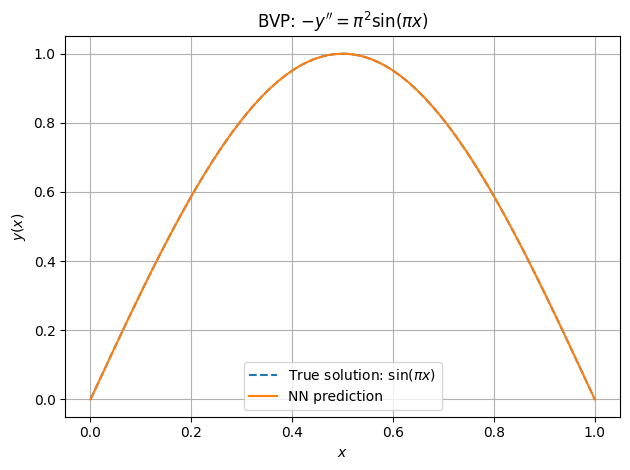

In [43]:
def compute_derivative(y, x):
    return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

# Loss function
def loss_function_bvp(model, x_collocation, gamma=100.0):
    x_collocation.requires_grad_(True)
    y = model(x_collocation)
    dy_dx = compute_derivative(y, x_collocation)
    d2y_dx2 = compute_derivative(dy_dx, x_collocation)

    # PDE residual: -y'' - pi^2 sin(pi x)
    f = torch.pi**2 * torch.sin(torch.pi * x_collocation)
    residual = -d2y_dx2 - f
    loss_pde = torch.mean(residual**2)

    # Enforce boundary conditions: y(0) = 0, y(1) = 0
    y0 = model(torch.tensor([[0.0]], dtype=torch.float32))
    y1 = model(torch.tensor([[1.0]], dtype=torch.float32))
    loss_bc = (y0**2 + y1**2).mean()

    return loss_pde + gamma * loss_bc

# Training loop
def train_bvp(model, epochs=3000, lr=1e-3, n_collocation=100, gamma=100.0, verbose=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    x_collocation = torch.linspace(0, 1, n_collocation).view(-1, 1)

    loss_history = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_function_bvp(model, x_collocation, gamma=gamma)
        loss.backward()
        optimizer.step()

        if verbose and epoch % 500 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.6f}")
        loss_history.append(loss.item())
    return loss_history

# Evaluation and plotting
def plot_bvp_solution(model):
    x_test = torch.linspace(0, 1, 200).view(-1, 1)
    with torch.no_grad():
        y_pred = model(x_test).numpy()
    y_true = np.sin(np.pi * x_test.numpy())

    plt.plot(x_test, y_true, "--", label="True solution: $\\sin(\\pi x)$")
    plt.plot(x_test, y_pred, label="NN prediction")
    plt.title("BVP: $-y'' = \\pi^2 \\sin(\\pi x)$")
    plt.xlabel("$x$")
    plt.ylabel("$y(x)$")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ---- Example usage ----
model = FeedforwardNN(input_dim=1, output_dim=1, hidden_layers=3, hidden_units=20, activation='swish')
train_bvp(model, epochs=3000, lr=1e-3, gamma=100.0)
plot_bvp_solution(model)

In [40]:
activations = ['tanh', 'relu']
layer_counts = list(range(1, 11))   # 1 to 10 layers
widths = list(range(1, 21))         # 1 to 20 neurons per layer

results = []

for act in activations:
    for layers in layer_counts:
        for width in widths:
            print(f"Training model: activation={act}, layers={layers}, width={width}")
            model = FeedforwardNN(input_dim=1, output_dim=1,
                                  hidden_layers=layers,
                                  hidden_units=width,
                                  activation=act)

            start_time = time.time()
            train_bvp(model, epochs=2500, lr=1e-3, gamma=100.0, verbose=False)
            duration = time.time() - start_time

            # Evaluate PDE residual MSE
            x_eval = torch.linspace(0, 1, 200).view(-1, 1)
            f_eval = torch.pi**2 * torch.sin(torch.pi * x_eval)
            x_eval.requires_grad_(True)
            y_pred = model(x_eval)
            dy_dx = compute_derivative(y_pred, x_eval)
            d2y_dx2 = compute_derivative(dy_dx, x_eval)
            residual = -d2y_dx2 - f_eval
            mse = torch.mean(residual**2).item()

            results.append({
                "activation": act,
                "layers": layers,
                "width": width,
                "mse": mse,
                "train_time_sec": duration
            })

# Save results
results_df = pd.DataFrame(results)
results_df.to_csv("Data/BVP_data/poisson_bvp_results.csv", index=False)

Training model: activation=tanh, layers=1, width=1
Training model: activation=tanh, layers=1, width=2
Training model: activation=tanh, layers=1, width=3
Training model: activation=tanh, layers=1, width=4
Training model: activation=tanh, layers=1, width=5
Training model: activation=tanh, layers=1, width=6
Training model: activation=tanh, layers=1, width=7
Training model: activation=tanh, layers=1, width=8
Training model: activation=tanh, layers=1, width=9
Training model: activation=tanh, layers=1, width=10
Training model: activation=tanh, layers=1, width=11
Training model: activation=tanh, layers=1, width=12
Training model: activation=tanh, layers=1, width=13
Training model: activation=tanh, layers=1, width=14
Training model: activation=tanh, layers=1, width=15
Training model: activation=tanh, layers=1, width=16
Training model: activation=tanh, layers=1, width=17
Training model: activation=tanh, layers=1, width=18
Training model: activation=tanh, layers=1, width=19
Training model: activ

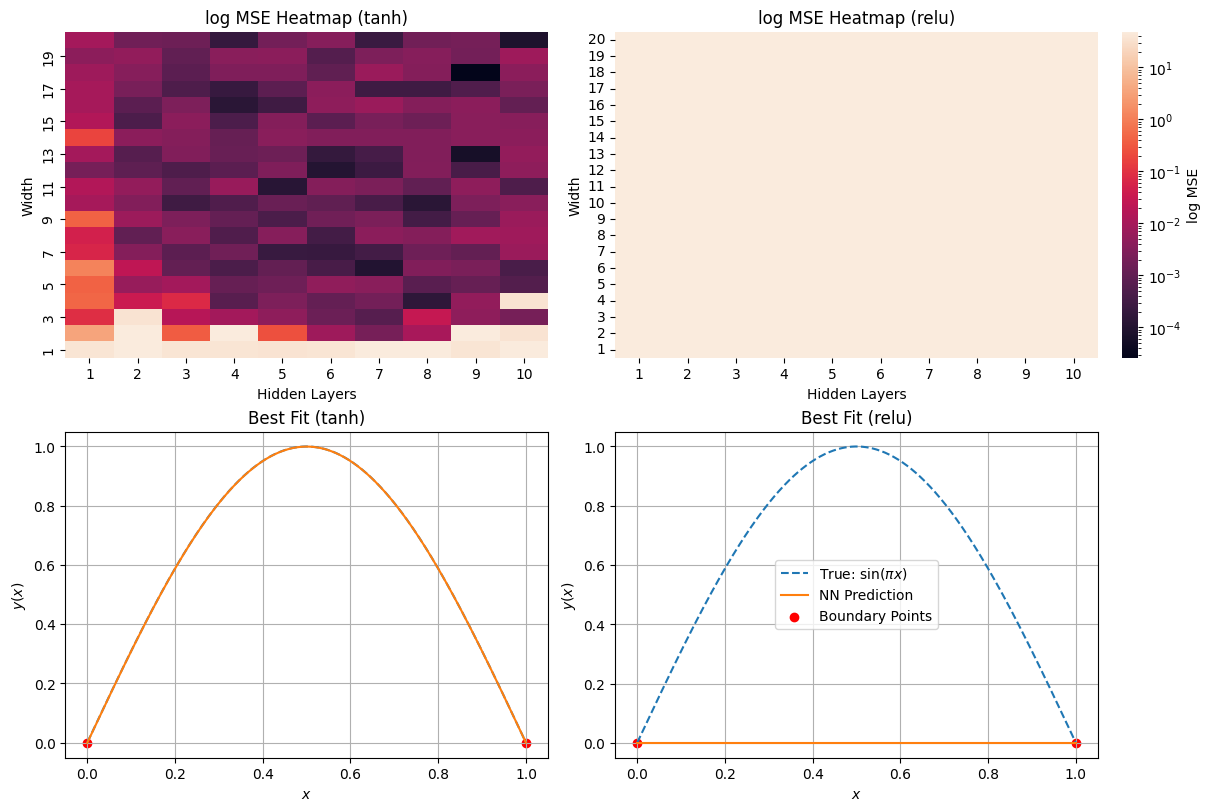

In [44]:
results_df = pd.read_csv("Data/BVP_data/poisson_bvp_results.csv")

# Normalisation for shared heatmap scale
vmin = results_df["mse"].min()
vmax = results_df["mse"].max()
log_norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)

# Find best configs
best_configs = {}
for act in results_df["activation"].unique():
    df_sub = results_df[results_df["activation"] == act]
    best_configs[act] = df_sub.loc[df_sub["mse"].idxmin()]

# === Setup combined plot ===
fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

# === Loop through activations ===
for j, act in enumerate(["tanh", "relu"]):
    df_sub = results_df[results_df["activation"] == act]
    heatmap_data = df_sub.pivot(index="width", columns="layers", values="mse")

    # Plot heatmap
    sns.heatmap(
        heatmap_data,
        cmap="rocket",
        norm=log_norm,
        ax=axes[0, j],
        cbar=(j == 1),
        cbar_kws={"label": "log MSE"}
    )
    axes[0, j].invert_yaxis()
    axes[0, j].set_title(f"log MSE Heatmap ({act})")
    axes[0, j].set_xlabel("Hidden Layers")
    axes[0, j].set_ylabel("Width")

    # Retrain best model
    config = best_configs[act]
    layers = int(config['layers'])
    width = int(config['width'])

    model = FeedforwardNN(1, 1, hidden_layers=layers, hidden_units=width, activation=act)
    train_bvp(model, epochs=2500, lr=1e-3, gamma=100.0, verbose=False)

    # Evaluation
    x = torch.linspace(0, 1, 500).view(-1, 1)
    y_true = torch.sin(np.pi * x)
    with torch.no_grad():
        y_pred = model(x).numpy()

    # Plot best-fit curve
    ax = axes[1, j]
    ax.plot(x.numpy(), y_true.numpy(), "--", label="True: $\\sin(\\pi x)$")
    ax.plot(x.numpy(), y_pred, label="NN Prediction")
    ax.scatter([0, 1], [0, 0], color="red", label="Boundary Points")
    ax.set_title(f"Best Fit ({act})")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y(x)$")
    ax.grid(True)
    if j == 1:
        ax.legend()

# Save combined figure
plt.savefig("report/graphics/bvp_poisson_combined.png", dpi=300, bbox_inches="tight")
plt.show()

Epoch 0, Loss: 15.169590
Epoch 500, Loss: 1.000019
Epoch 1000, Loss: 1.000002
Epoch 1500, Loss: 1.000000
Epoch 2000, Loss: 1.000000
Epoch 2500, Loss: 1.000000
Epoch 3000, Loss: 1.000000
Epoch 3500, Loss: 1.000000
Epoch 4000, Loss: 1.000000
Epoch 4500, Loss: 1.000000


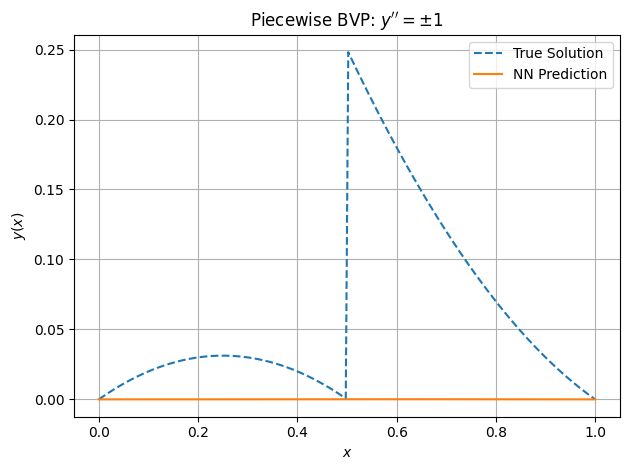

In [46]:
def compute_derivative(y, x):
    return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

def rhs_piecewise(x):
    return torch.where(x < 0.5, -torch.ones_like(x), torch.ones_like(x))

def loss_function_piecewise_bvp(model, x_collocation, gamma=100.0):
    x_collocation.requires_grad_(True)
    y = model(x_collocation)
    dy_dx = compute_derivative(y, x_collocation)
    d2y_dx2 = compute_derivative(dy_dx, x_collocation)

    f = rhs_piecewise(x_collocation)
    loss_pde = torch.mean((d2y_dx2 - f)**2)

    y0 = model(torch.tensor([[0.0]]))
    y1 = model(torch.tensor([[1.0]]))
    loss_bc = (y0**2 + y1**2).mean()

    return loss_pde + gamma * loss_bc

def train_piecewise_bvp(model, epochs=3000, lr=1e-3, n_collocation=100, verbose=False):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    x_col = torch.linspace(0, 1, n_collocation).view(-1, 1)

    for epoch in range(epochs):
        opt.zero_grad()
        loss = loss_function_piecewise_bvp(model, x_col)
        loss.backward()
        opt.step()

        if verbose and epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
    return model

# Plot
def plot_solution(model):
    x = torch.linspace(0, 1, 200).view(-1, 1)
    y_pred = model(x).detach().numpy()
    x_np = x.numpy()
    y_true = np.where(x_np < 0.5, -0.5*x_np**2 + 0.25*x_np, 0.5*x_np**2 - 1.25*x_np + 0.75)
    plt.plot(x_np, y_true, '--', label='True Solution')
    plt.plot(x_np, y_pred, label='NN Prediction')
    plt.legend()
    plt.grid(True)
    plt.title('Piecewise BVP: $y\'\' = \\pm 1$')
    plt.xlabel('$x$')
    plt.ylabel('$y(x)$')
    plt.tight_layout()
    plt.show()

# Run
model = FeedforwardNN(1, 1, hidden_layers=10, hidden_units=20, activation='relu')
model = train_piecewise_bvp(model, epochs=5000, verbose=True)
plot_solution(model)

In [30]:
activations = ['tanh', 'relu']
layer_counts = list(range(1, 11))   # 1 to 10 layers
widths = list(range(1, 21))         # 1 to 20 neurons per layer

results = []

for act in activations:
    for layers in layer_counts:
        for width in widths:
            print(f"Training model: activation={act}, layers={layers}, width={width}")
            model = FeedforwardNN(input_dim=1, output_dim=1,
                                  hidden_layers=layers,
                                  hidden_units=width,
                                  activation=act)

            start_time = time.time()
            train_piecewise_bvp(model, epochs=2500, lr=1e-3, verbose=False)
            duration = time.time() - start_time

            # Evaluate on dense grid
            x_eval = torch.linspace(0, 1, 200).view(-1, 1)
            f_eval = rhs_piecewise(x_eval)
            x_eval.requires_grad_(True)
            y_pred = model(x_eval)
            dy_dx = compute_derivative(y_pred, x_eval)
            d2y_dx2 = compute_derivative(dy_dx, x_eval)
            residual = d2y_dx2 - f_eval
            mse = torch.mean(residual**2).item()

            results.append({
                "activation": act,
                "layers": layers,
                "width": width,
                "mse": mse,
                "train_time_sec": duration
            })

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv("Data/BVP_data/piecewise_bvp_results.csv", index=False)

Training model: activation=tanh, layers=1, width=1
Training model: activation=tanh, layers=1, width=2
Training model: activation=tanh, layers=1, width=3
Training model: activation=tanh, layers=1, width=4
Training model: activation=tanh, layers=1, width=5
Training model: activation=tanh, layers=1, width=6
Training model: activation=tanh, layers=1, width=7
Training model: activation=tanh, layers=1, width=8
Training model: activation=tanh, layers=1, width=9
Training model: activation=tanh, layers=1, width=10
Training model: activation=tanh, layers=1, width=11
Training model: activation=tanh, layers=1, width=12
Training model: activation=tanh, layers=1, width=13
Training model: activation=tanh, layers=1, width=14
Training model: activation=tanh, layers=1, width=15
Training model: activation=tanh, layers=1, width=16
Training model: activation=tanh, layers=1, width=17
Training model: activation=tanh, layers=1, width=18
Training model: activation=tanh, layers=1, width=19
Training model: activ

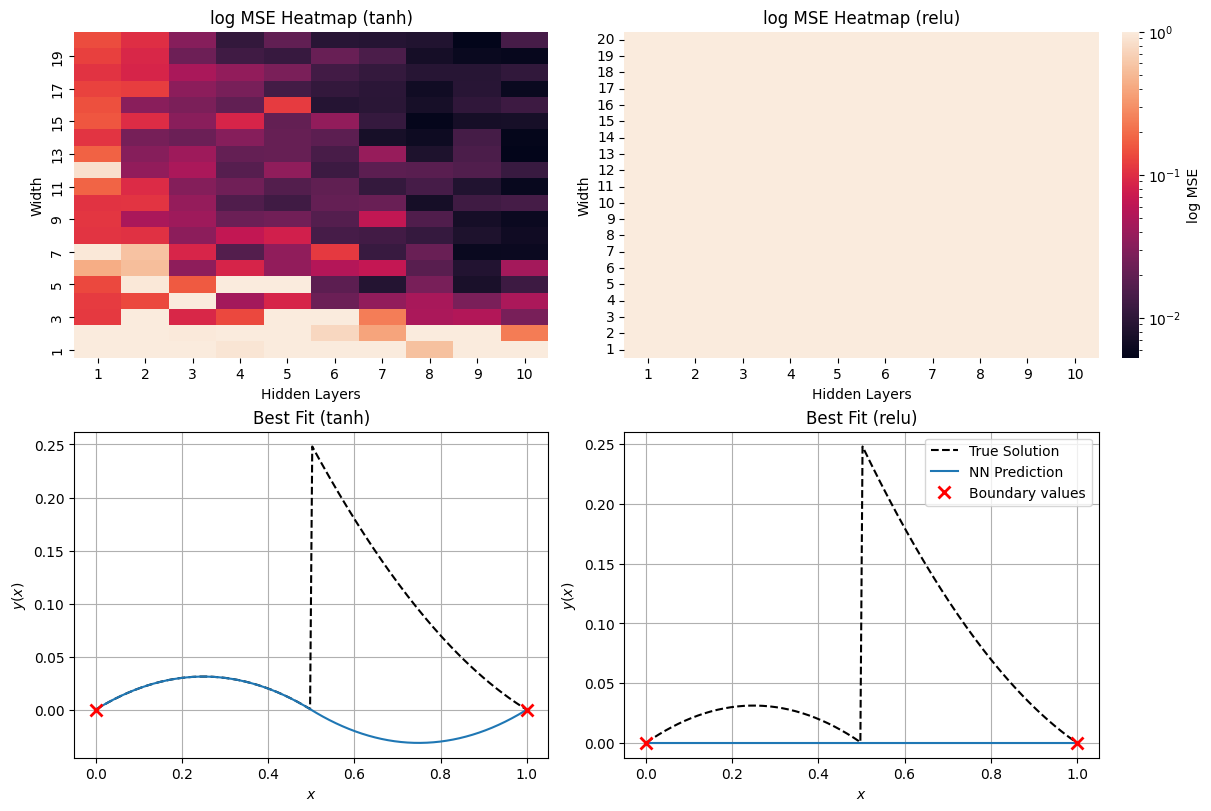

In [50]:
results_df = pd.read_csv("Data/BVP_data/piecewise_bvp_results.csv")

# Global colour scale for heatmaps 
vmin = results_df["mse"].min()
vmax = results_df["mse"].max()
log_norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)

# best configurations 
best_configs = {}
for act in results_df["activation"].unique():
    df_sub = results_df[results_df["activation"] == act]
    best_configs[act] = df_sub.loc[df_sub["mse"].idxmin()]

# True solution  
def true_solution(x_np):
    x = x_np.squeeze()
    y = np.where(
        x < 0.5,
        -0.5 * x**2 + 0.25 * x,
        0.5 * x**2 - 1.25 * x + 0.75
    )
    return y

# make plots 
fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

for j, act in enumerate(["tanh", "relu"]):
    # Heatmap
    df_subset = results_df[results_df["activation"] == act]
    heatmap_data = df_subset.pivot(index="width", columns="layers", values="mse")
    sns.heatmap(
        heatmap_data, cmap="rocket", norm=log_norm,
        ax=axes[0, j], cbar=(j == 1),
        cbar_kws={"label": "log MSE"}
    )
    axes[0, j].invert_yaxis()
    axes[0, j].set_title(f"log MSE Heatmap ({act})")
    axes[0, j].set_xlabel("Hidden Layers")
    axes[0, j].set_ylabel("Width")

    # Best fit plot
    config = best_configs[act]
    layers = int(config["layers"])
    width = int(config["width"])
    model = FeedforwardNN(input_dim=1, output_dim=1,
                          hidden_layers=layers,
                          hidden_units=width,
                          activation=act)
    train_piecewise_bvp(model, epochs=5000, verbose=False)

    x_plot = torch.linspace(0, 1, 200).view(-1, 1)
    with torch.no_grad():
        y_pred = model(x_plot).numpy()
    y_true = true_solution(x_plot.numpy())

    axes[1, j].plot(x_plot.numpy(), y_true, "--", label="True Solution", color="black")
    axes[1, j].plot(x_plot.numpy(), y_pred, label="NN Prediction", color="C0")
    axes[1, j].plot(0, 0, 'rx', label="Boundary values" if j == 1 else None, markersize=8, markeredgewidth=2)
    axes[1, j].plot(1, 0, 'rx', markersize=8, markeredgewidth=2)
    axes[1, j].set_title(f"Best Fit ({act})")
    axes[1, j].set_xlabel("$x$")
    axes[1, j].set_ylabel("$y(x)$")
    axes[1, j].grid(True)
    if j == 1:
        axes[1, j].legend()

# Save  figure
plt.savefig("report/graphics/bvp_piecewise_combined.png", dpi=300, bbox_inches="tight")
plt.show()